In [1]:
import sys
sys.path.append('../sgmm')
sys.path.append('../metrics')
sys.path.append('../Misc')
sys.path.append('../visual')
sys.path.append('../otherModels')
sys.path.append('../LogOdds')

In [2]:
import numpy as np
import pandas as pd
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults
from mlModels import logisticRegressionCv2, neural_nets, randomforests,\
kmeansLogRegr, xboost, gradboost,kmeansBNB
from sklearn.naive_bayes import BernoulliNB
from supervisedBmm import SupervisedBMM
from utility import entropy,asymm_entropy,purity
from ftest_logodds import ftest_uncorr
from ftest_logodds import restest
#from clustmap import plotclustmap
#from clustmap_newborn import plotclustmap
from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/SPARCS_Subsets/Obsolete/sparcs25%Circ_DeHos_Outflow_Region.csv") 

d_circ_tr, d_circ_te = train_test_split(sparcs, test_size=0.2, random_state = 1512)

print(d_circ_tr.shape[0], d_circ_tr.shape[1])

39888 301


In [5]:
# metric matrix columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

In [6]:
# feature list
features = list(sparcs.iloc[:,:-1])

In [7]:
#Preparing the data
Xtrain, Xtest = d_circ_tr.iloc[:,0:-1].values, d_circ_te.iloc[:,0:-1].values
ytrain, ytest = d_circ_tr.iloc[:,-1].values.astype(int), d_circ_te.iloc[:,-1].values.astype(int)

# Nonclustering Classification

In [8]:
# Fitting a Bernoulli Naive Bayes
bnb = BernoulliNB(alpha= 1,class_prior=[0.75,0.25])
bnb.fit(Xtrain, ytrain)
probTrainNB,probTestNB = bnb.predict_proba(Xtrain)[:,1], bnb.predict_proba(Xtest)[:,1]
tau = optimalTau(probTrainNB, ytrain)
metTest,_ = calc_metrics(custom_prob = probTestNB.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNB.copy(), tau = tau, y = ytrain)
metTestNB = pd.DataFrame( [metTest], columns = columns)
metTrainNB = pd.DataFrame( [metTrain], columns = columns)

In [9]:
#FITTING L1 LOGISTIC REGRESSION
Cs = [1,10,100,1000]
pL1, probTestL1, probTrainL1 = logisticRegressionCv2( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest, Cs = Cs )
tau = optimalTau(probTrainL1, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestL1.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainL1.copy(), tau = tau, y = ytrain)
metTestL1 = pd.DataFrame( [metTest], columns = columns)
metTrainL1 = pd.DataFrame( [metTrain], columns = columns)

In [10]:
#Fitting Neural Nets
pNN, probTestNN, probTrainNN = neural_nets( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest,
                                                  h_l_s = (4 ,4, 2))
tau = optimalTau(probTrainNN, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestNN.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNN.copy(), tau = tau, y = ytrain)
metTestNN = pd.DataFrame( [metTest], columns = columns)
metTrainNN = pd.DataFrame( [metTrain], columns = columns)

In [11]:
#RANDOM FORESTS
params, probTest, probTrain = randomforests(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestRF = pd.DataFrame( [metTest], columns = columns)
metTrainRF = pd.DataFrame( [metTrain], columns = columns)


In [12]:
#Ada boost
params, probTest, probTrain = xboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestXB = pd.DataFrame( [metTest], columns = columns)
metTrainXB = pd.DataFrame( [metTrain], columns = columns)

In [13]:
#Grad boost
params, probTest, probTrain = gradboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestGB = pd.DataFrame( [metTest], columns = columns)
metTrainGB = pd.DataFrame( [metTrain], columns = columns)

# Sequential clustering + classification

In [14]:
#Kmeans + LG

np.random.seed( seed = 0 )

n_clusters = 7

Cs = [1,10,100,1000]
kmeansParams = kmeansLogRegr(Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, Cs = Cs, n_clusters = n_clusters)

modelsKM = kmeansParams['models']
labTrKM, labTestKM  = kmeansParams['labelsTrain'], kmeansParams['labelsTest']


# KMS class accuracy
metTrainKMc, metTestKMc = metrics_cluster(models = modelsKM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKM,
                                        trainlabels = labTrKM,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [15]:
# KMS LG overall accuaracy
probTr= np.array([])
for i in range(len(kmeansParams['probTrain'])):
    probTr = np.append(probTr,kmeansParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKM==i])

probTe= np.array([])
for i in range(len(kmeansParams['probTest'])):
    probTe = np.append(probTe,kmeansParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKM==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMS = pd.DataFrame( [metTrain], columns = columns)
metTestKMS = pd.DataFrame( [metTest], columns = columns)

In [16]:
# kmeans + NB classifier

np.random.seed( seed = 0 )

n_clusters = 7

kmeansNBParams = kmeansBNB( Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, n_clusters = n_clusters)
modelsKMNB = kmeansNBParams['models']
labTrKMNB, labTestKMNB  = kmeansNBParams['labelsTrain'], kmeansNBParams['labelsTest']


# KMS class accuracy
metTrainKMcNB, metTestKMcNB = metrics_cluster(models = modelsKMNB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKMNB,
                                        trainlabels = labTrKMNB,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [17]:
# KMS + NB overall accuaracy
probTr= np.array([])
for i in range(len(kmeansNBParams['probTrain'])):
    probTr = np.append(probTr,kmeansNBParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKMNB==i])

probTe= np.array([])
for i in range(len(kmeansNBParams['probTest'])):
    probTe = np.append(probTe,kmeansNBParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKMNB==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMSNB = pd.DataFrame( [metTrain], columns = columns)
metTestKMSNB = pd.DataFrame( [metTest], columns = columns)

In [18]:
# GMM + Classification (LG) (simple = 1)
np.random.seed( seed = 0 )

max_iter = 30
max_iter2 = 30
n_clusters = 7

model = SupervisedGMM( max_iter = max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain, simple = 1, kmeans = 1)
# Retrieve memberships and labels
mTrainGMMLG = model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain  = fitP['labTrain']
mTestGMMLG = model.predict_GMMS(Xtest)
labTest = np.argmax( mTestGMMLG, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestGMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainGMMLG = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainGMMLGc, metTestGMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)



GMM iteration: 0, error: 0.0070837247516336
GMM iteration: 1, error: 0.004340625687674227
GMM iteration: 2, error: 0.0040695554872262445
GMM iteration: 3, error: 0.010929164917977598
GMM iteration: 4, error: 0.00820912551749296
GMM iteration: 5, error: 0.0027346063175514366
GMM iteration: 6, error: 0.0007234016161951073


In [19]:
# BMM + Classification (LG)
np.random.seed( seed = 0 )

max_iter = 30
max_iter2 = 30
n_clusters = 7

modelB = SupervisedBMM( n_clusters = n_clusters,max_iter = max_iter,max_iter2 = max_iter2)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain,simple=1, kmeans= 1)

mTrainBMMLG = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrain  = fitP['labTrain']
mTestBMMLG = modelB.predict_BMMS(Xtest)
labTest = np.argmax( mTestBMMLG, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestBMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainBMMLG = pd.DataFrame( [metTrain], columns = columns)

metTrainBMMLGc, metTestBMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)


BMM iteration: 0, error: 0.0033387363339092793
BMM iteration: 1, error: 0.001673090886977198
BMM iteration: 2, error: 0.0013951462831235377
BMM iteration: 3, error: 0.0012268982126146348
BMM iteration: 4, error: 0.0010715152153612656
BMM iteration: 5, error: 0.0009119777424821162


In [20]:
# train SGMM model with Log Regression
np.random.seed( seed = 94469 )

max_iter = 30
max_iter2 = 30
n_clusters = 7

model = SupervisedGMM( max_iter=max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain)

# Retrieve memberships and labels
mTrainSGMM = model.mTrain
logisRegreSGMM = model.LogRegr
fitP = model.fitParams
labTrainSGMM  = fitP['labTrain']
mTestSGMM = model.predict_GMMS(Xtest)
labTestSGMM = np.argmax( mTestSGMM, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSGMM = pd.DataFrame( [metTest], columns = columns)
metTrainSGMM = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainSGc, metTestSGc = metrics_cluster(models = logisRegreSGMM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestSGMM,
                                        trainlabels = labTrainSGMM,
                                        Xtrain = Xtrain, Xtest = Xtest)

GMM iteration: 0, error: 0.19600469100396917
GMM iteration: 1, error: 0.10580530749126546
GMM iteration: 2, error: 0.02414035191018011
GMM iteration: 3, error: 0.0053016022607052776
GMM iteration: 4, error: 0.0012897451797265664
GMM iteration: 5, error: 0.0003292113293513271


In [21]:
# train SBMM model with Log Regression

np.random.seed( seed = 9765  )

max_iter = 30
max_iter2 = 30
n_clusters = 7

modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2,verbose =0)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrainSBMM = modelB.mTrain
logisRegreB = modelB.LogRegr
fitPB = modelB.fitParams
labTrainSBMM  = fitPB['labTrain']
mTestSBMM = modelB.predict_BMMS(Xtest)
labTestSBMM = np.argmax( mTestSBMM, axis = 1 )

probTestB, probTrainB = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tauB = optimalTau(probTrainB, ytrain)
metTestB,_ = calc_metrics(custom_prob = probTestB.copy(), tau = tauB, y = ytest)
metTrainB ,_= calc_metrics(custom_prob = probTrainB.copy(), tau = tauB, y = ytrain)
metTestSBMM = pd.DataFrame( [metTestB], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrainB], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegreB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestSBMM,
                                        trainlabels = labTrainSBMM,
                                        Xtrain = Xtrain, Xtest = Xtest)

BMM iteration: 0, error: 0.06747589399893002
BMM iteration: 1, error: 0.01429178544334944
BMM iteration: 2, error: 0.013568742703090341
BMM iteration: 3, error: 0.04029620641844425
BMM iteration: 4, error: 0.0814641138102845
BMM iteration: 5, error: 0.0787127738827347
BMM iteration: 6, error: 0.054827407217991966
BMM iteration: 7, error: 0.03228998664053897
BMM iteration: 8, error: 0.019589538113114292
BMM iteration: 9, error: 0.012353730017538598
BMM iteration: 10, error: 0.007860084190610716
BMM iteration: 11, error: 0.005323977512962532
BMM iteration: 12, error: 0.0041762253519136575
BMM iteration: 13, error: 0.003858071805608902
BMM iteration: 14, error: 0.00373756806695684
BMM iteration: 15, error: 0.0038235782502489464
BMM iteration: 16, error: 0.0037810266963984943
BMM iteration: 17, error: 0.0037594194234194674
BMM iteration: 18, error: 0.0031440676399008623
BMM iteration: 19, error: 0.0020995155448616685
BMM iteration: 20, error: 0.0015030231203171376
BMM iteration: 21, error:

# Overall predition accuracy

In [22]:
# Comparison acucuracy with other methods
trainmet = pd.concat([metTrainNB, metTrainL1,metTrainNN,metTrainRF,metTrainXB,metTrainGB, metTrainKMS,metTrainKMSNB,metTrainGMMLG,metTrainBMMLG,metTrainSGMM,metTrainSBMM],ignore_index=True)
testmet = pd.concat([metTestNB, metTestL1,metTestNN,metTestRF,metTestXB,metTestGB, metTestKMS,metTestKMSNB,metTestGMMLG,metTestBMMLG,metTestSGMM,metTestSBMM],ignore_index=True)
method = ['Naive Bayes','L1 Log Reg','Neural Network','Random Forest','AdaBoost','GradBoost','KMS + Log Reg','KMS + NB', 'GMM + Log Reg', 'BMM + Log Reg', 'SGMM w/ Log Reg', 'SBMM w/ Log Reg']
trainmet.insert(8,'method',method)
testmet.insert(8,'method',method)

In [23]:
print( 'Overall prediction accuracy')
testmet.iloc[:,8:].round(2)

Overall prediction accuracy


,method,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,Naive Bayes,0.22,0.78,0.75,0.52,0.77,0.76,0.62,0.83
1,L1 Log Reg,0.13,0.87,0.69,0.63,0.82,0.78,0.66,0.87
2,Neural Network,0.14,0.86,0.71,0.62,0.82,0.78,0.66,0.88
3,Random Forest,0.12,0.88,0.64,0.64,0.82,0.76,0.64,0.85
4,AdaBoost,0.19,0.81,0.71,0.55,0.78,0.76,0.62,0.84
5,GradBoost,0.19,0.81,0.73,0.56,0.79,0.77,0.63,0.85
6,KMS + Log Reg,0.16,0.84,0.71,0.59,0.81,0.78,0.65,0.86
7,KMS + NB,0.17,0.83,0.70,0.57,0.80,0.77,0.63,0.86
8,GMM + Log Reg,0.14,0.86,0.70,0.62,0.82,0.78,0.66,0.87
9,BMM + Log Reg,0.14,0.86,0.70,0.61,0.82,0.78,0.66,0.87


# Cadre wise prediction accuracy

In [24]:
print('Kmeans + LG')
print(metTestKMc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
#print('Kmeans + NB')
#print(metTestKMcNB.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('GMM + LG')
print(metTestGMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('BMM + LG')
print(metTestBMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('SGMM w/ LG')
print(metTestSGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]) #.iloc [[1,0,2,3,4],:]) 
print('SBMM w/ LG')
print(metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])

Kmeans + LG
     size  high_cost%    f1   auc
0  1259.0        0.16  0.52  0.84
1  1423.0        0.18  0.59  0.85
2  1631.0        0.19  0.56  0.83
3   924.0        0.20  0.61  0.87
4  1799.0        0.23  0.62  0.85
5  1456.0        0.24  0.63  0.85
6  1480.0        0.51  0.76  0.82
GMM + LG
     size  high_cost%    f1   auc
0  1110.0        0.16  0.55  0.85
1  1260.0        0.17  0.59  0.86
2   863.0        0.18  0.59  0.87
3  1502.0        0.19  0.59  0.85
4  1548.0        0.22  0.64  0.87
5  1361.0        0.23  0.63  0.86
6  2328.0        0.42  0.74  0.85
BMM + LG
     size  high_cost%    f1   auc
0  1223.0        0.15  0.53  0.85
1   885.0        0.18  0.59  0.87
2  1613.0        0.18  0.56  0.85
3  1404.0        0.18  0.58  0.85
4  1775.0        0.22  0.62  0.86
5  1395.0        0.23  0.63  0.85
6  1677.0        0.51  0.76  0.83
SGMM w/ LG
     size  high_cost%    f1   auc
0   199.0        0.22  0.55  0.82
1  8324.0        0.24  0.65  0.87
2   404.0        0.27  0.69  0.89
3   526

# Stratification

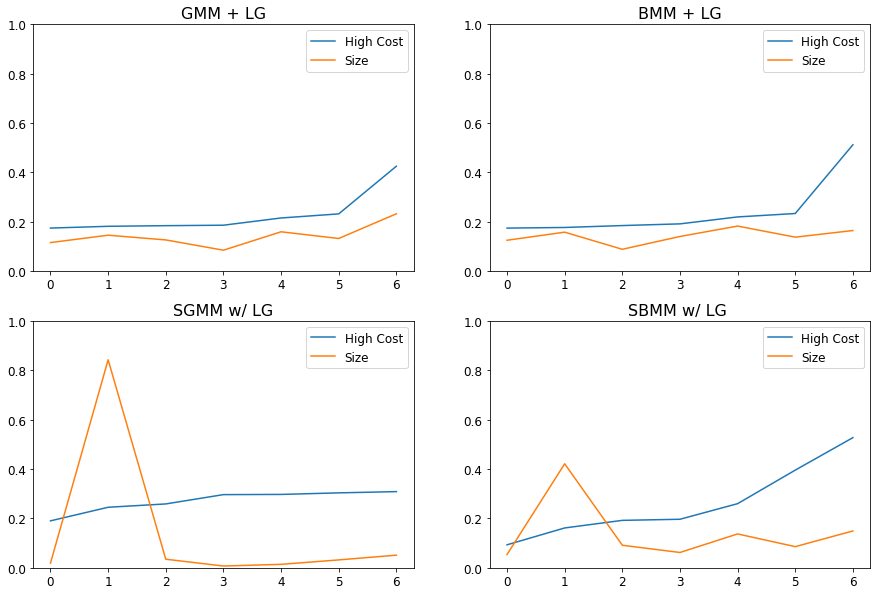

In [25]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y=sorted(metTrainGMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y= metTrainGMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('GMM + LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 2)
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y=sorted(metTrainBMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y= metTrainBMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('BMM + LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)


plt.subplot(2, 2, 3)
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y=sorted(metTrainSGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y= metTrainSGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SGMM w/ LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 4)
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.show()

# Class entropy by stratification

In [26]:
# calculate cadre entropy
class_prior = d_circ_tr['Target'].value_counts(normalize=True)[1]
purityKMSLGlow,purityKMSLGhigh= purity(metTrainKMc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainKMc.sort_values(by ='high_cost%')['size'].values,class_prior)
print('purity of low/high risk by KMS + LG is :{} and :{}' .format(purityKMSLGlow,purityKMSLGhigh ))
purityGMMLGlow,purityGMMLGhigh= purity(metTrainGMMLGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainGMMLGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by GMM+ LG is :{} and :{}'.format( purityGMMLGlow,purityGMMLGhigh ))
purityBMMLGlow,purityBMMLGhigh= purity(metTrainBMMLGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainBMMLGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by BMM+ LG is :{} and :{}'.format (purityBMMLGlow,purityBMMLGhigh ) )
puritySGMMLGlow,puritySGMMLGhigh = purity(metTrainSGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainSGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by SGMM w/ LG is :{} and :{} '.format (puritySGMMLGlow,puritySGMMLGhigh ) )
puritySBMMLGlow,puritySBMMLGhigh= purity(metTrainSBc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainSBc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by SBMM w/ LG is :{} and :{}'.format (puritySBMMLGlow,puritySBMMLGhigh) )

purity of low/high risk by KMS + LG is :0.03320491804473802 and :0.21572335978857782
purity of low/high risk by GMM+ LG is :0.03815451739737996 and :0.11094857593757645
purity of low/high risk by BMM+ LG is :0.038330472171535956 and :0.21485115581000336
purity of low/high risk by SGMM w/ LG is :0.023273999348761287 and :0.01536945674872403 
purity of low/high risk by SBMM w/ LG is :0.22721806444985682 and :0.23433068048210792


# Cadre Assigment confidence 

In [27]:
# conditional entropy for each method
condEntropyGMMLG = entropy(mTrainGMMLG[:,np.argsort(metTrainGMMLGc['high_cost%'])],n_clusters)
condEntropyBMMLG = entropy(mTrainBMMLG[:,np.argsort(metTrainBMMLGc['high_cost%'])],n_clusters)
condEntropySGMM = entropy(mTrainSGMM[:,np.argsort(metTrainSGc['high_cost%'])],n_clusters)
condEntropySBMM = entropy(mTrainSBMM[:,np.argsort(metTrainSBc['high_cost%'])],n_clusters)
print('GMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyGMMLG)))
print('BMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyBMMLG)))
print('SGMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySGMM)))
print('SBMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySBMM)))

GMM + LG average conditional entropy for each cadre is  0.00608519318333053
BMM + LG average conditional entropy for each cadre is  0.10563269411817651
SGMM w/ LG average conditional entropy for each cadre is  0.02512464873914274
SBMM w/ LG average conditional entropy for each cadre is  0.17209102606771212


In [28]:
# conditional entropy for each cluster
print('GMM + LG conditional entropy for each cadre is  {}'.format(condEntropyGMMLG))
print('BMM + LG conditional entropy for each cadre is  {}'.format(condEntropyBMMLG))
print('SGMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySGMM))
print('SBMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySBMM))

GMM + LG conditional entropy for each cadre is  [0.00259144 0.00223204 0.00246924 0.00342203 0.00251872 0.00291704
 0.02644584]
BMM + LG conditional entropy for each cadre is  [0.04429797 0.09451895 0.07206475 0.11226282 0.11465715 0.07070059
 0.23092663]
SGMM w/ LG conditional entropy for each cadre is  [0.03202643 0.00262142 0.01841709 0.06348199 0.02400622 0.02463145
 0.01068794]
SBMM w/ LG conditional entropy for each cadre is  [0.00703927 0.12806266 0.01393728 0.36067893 0.06768159 0.44342154
 0.18381591]
